In [26]:
import bz2
import json
import pandas as pd
import numpy as np
import ijson
import matplotlib.pyplot as plt
from io import StringIO

import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA


from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from SVDD.src.svdd import SVDD
from SVDD.src.visualize import Visualization as draw


import scipy as sp
import re

# Dataset import
The imported data set is already clean:
- In cases when LANL's snitching was unsuccessful, the number of source or destination packets was 0. I removed such connections.
- I dropped duplicate rows.

In [27]:
net_df=pd.read_hdf("/home/aimed/sicurezza_informatica/network/day_02.h5")

# Data Aggregation
As we can see, many lines share the same Time, SrcDevice, DstDevice, Protocol, SrcPort and DstPort. I therefore aggregates these rows, summing up the other features.

In [28]:
net_df=net_df.groupby(["SrcDevice","DstDevice","SrcPort","DstPort","Protocol","Time"])["Duration","SrcPackets","DestPackets","SrcBytes","DstBytes"].sum().reset_index()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


I realized that many wors still share the same Time, SrcDevice, DstDevice and Protocol, but using different ports. Since I'm going to create Time Series I can not handle multiple rows with the same time, so I decided to aggregate these lines and to drop out the features SrcPort and DstPort.

In [29]:
new_net_df=net_df.groupby(["SrcDevice","DstDevice","Protocol","Time"])["Duration","SrcPackets","DestPackets","SrcBytes","DstBytes"].sum().reset_index()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [30]:
pd.set_option('display.max_rows', 50)
new_net_df

,SrcDevice,DstDevice,Protocol,Time,Duration,SrcPackets,DestPackets,SrcBytes,DstBytes
0,ActiveDirectory,ActiveDirectory,6,123661,107,35,35,8066,28182
1,ActiveDirectory,ActiveDirectory,6,125117,72,18,14,7362,4634
2,ActiveDirectory,ActiveDirectory,6,130741,36,12,9,2942,3691
3,ActiveDirectory,ActiveDirectory,6,130742,144,48,53,10352,49310
4,ActiveDirectory,ActiveDirectory,6,134960,1776,48,67,7914,78054
...,...,...,...,...,...,...,...,...,...
18259756,VScanner,Comp661242,6,148134,28,11,7,6158,753
18259757,VScanner,Comp661242,6,148162,55,14,7,10806,753
18259758,VScanner,Comp661242,6,148659,1,7,7,1517,753
18259759,VScanner,Comp661242,6,148899,30,9,7,2502,753


# Data Processing

In [31]:
new_net_df["SrcOnDstPackets"]=new_net_df.SrcPackets/new_net_df.DestPackets

In [32]:
new_net_df["SrcOnDstBytes"]=new_net_df.SrcBytes/new_net_df.DstBytes

# Scaling and Principal Component Analysis

In [33]:
scaler=StandardScaler()
new_net_df[["Duration","SrcPackets","DestPackets","SrcBytes","DstBytes","SrcOnDstPackets","SrcOnDstBytes"]]=scaler.fit_transform(new_net_df[["Duration","SrcPackets","DestPackets","SrcBytes","DstBytes","SrcOnDstPackets","SrcOnDstBytes"]])

In [34]:
new_net_df

,SrcDevice,DstDevice,Protocol,Time,Duration,SrcPackets,DestPackets,SrcBytes,DstBytes,SrcOnDstPackets,SrcOnDstBytes
0,ActiveDirectory,ActiveDirectory,6,123661,-0.017204,-0.000463,-0.000394,-0.000572,-0.000719,-0.026787,-0.025224
1,ActiveDirectory,ActiveDirectory,6,125117,-0.017235,-0.000463,-0.000395,-0.000572,-0.000721,0.001564,-0.003904
2,ActiveDirectory,ActiveDirectory,6,130741,-0.017267,-0.000464,-0.000395,-0.000573,-0.000722,0.006289,-0.016862
3,ActiveDirectory,ActiveDirectory,6,130742,-0.017170,-0.000463,-0.000394,-0.000572,-0.000716,-0.036149,-0.026473
4,ActiveDirectory,ActiveDirectory,6,134960,-0.015702,-0.000463,-0.000393,-0.000572,-0.000713,-0.054927,-0.028249
...,...,...,...,...,...,...,...,...,...,...,...
18259756,VScanner,Comp661242,6,148134,-0.017275,-0.000464,-0.000395,-0.000572,-0.000722,0.029915,0.103953
18259757,VScanner,Comp661242,6,148162,-0.017250,-0.000464,-0.000395,-0.000572,-0.000722,0.072441,0.204991
18259758,VScanner,Comp661242,6,148659,-0.017299,-0.000464,-0.000395,-0.000573,-0.000722,-0.026787,0.003068
18259759,VScanner,Comp661242,6,148899,-0.017273,-0.000464,-0.000395,-0.000573,-0.000722,0.001564,0.024479


In [35]:

pca = PCA(n_components=1,svd_solver='auto')
new_net_df["pca"]=pca.fit_transform(new_net_df[["SrcOnDstPackets","SrcOnDstBytes"]])

In [36]:
pca.explained_variance_ratio_

array([0.92484328])

In [37]:
new_net_df.describe()

,Protocol,Time,Duration,SrcPackets,DestPackets,SrcBytes,DstBytes,SrcOnDstPackets,SrcOnDstBytes,pca
count,1.825976e+07,1.825976e+07,1.825976e+07,1.825976e+07,1.825976e+07,1.825976e+07,1.825976e+07,1.825976e+07,1.825976e+07,1.825976e+07
mean,6.426749e+00,1.467031e+05,8.649590e-18,3.606752e-20,-1.236219e-19,-1.884364e-19,-3.336793e-20,-9.077010e-17,2.035930e-17,6.042416e-18
std,2.124176e+00,1.485323e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.360032e+00
min,6.000000e+00,1.187830e+05,-1.729981e-02,-4.639801e-04,-3.950133e-04,-5.733257e-04,-7.219960e-04,-1.260157e-01,-2.990891e-02,-1.102553e-01
25%,6.000000e+00,1.337210e+05,-1.729981e-02,-4.638904e-04,-3.949662e-04,-5.732875e-04,-7.219664e-04,-2.678733e-02,-2.407349e-02,-3.398662e-02
50%,6.000000e+00,1.467570e+05,-1.729891e-02,-4.637707e-04,-3.948956e-04,-5.732153e-04,-7.218272e-04,-1.686449e-02,-1.748086e-02,-2.085556e-02
75%,6.000000e+00,1.593140e+05,-1.718733e-02,-4.635315e-04,-3.947309e-04,-5.728318e-04,-7.213939e-04,1.290402e-02,-8.350193e-03,-1.457627e-03
max,1.700000e+01,1.727990e+05,1.854794e+03,4.015009e+03,4.234312e+03,3.824835e+03,3.674828e+03,3.487553e+03,4.027256e+03,5.313773e+03


# Time Series Extraction and Padding

In [19]:
srces=list(set(new_net_df["SrcDevice"]))

In [20]:
srces

['Comp821443',
 'Comp465780',
 'Comp477929',
 'Comp410198',
 'Comp378365',
 'Comp170919',
 'Comp629537',
 'Comp851438',
 'Comp981541',
 'Comp926401',
 'Comp832589',
 'Comp213870',
 'Comp057426',
 'Comp039713',
 'Comp908076',
 'Comp253114',
 'Comp598160',
 'Comp191625',
 'Comp611106',
 'Comp980737',
 'Comp412692',
 'Comp450249',
 'Comp519126',
 'Comp424608',
 'Comp821204',
 'Comp513869',
 'Comp171856',
 'Comp503124',
 'Comp104828',
 'Comp688770',
 'Comp764657',
 'Comp077499',
 'Comp437344',
 'Comp406498',
 'Comp739683',
 'Comp841607',
 'Comp474419',
 'Comp267285',
 'Comp328334',
 'Comp683515',
 'Comp931581',
 'Comp755860',
 'Comp159661',
 'Comp067664',
 'Comp154252',
 'Comp520247',
 'Comp745381',
 'Comp792408',
 'Comp247438',
 'Comp604859',
 'Comp345099',
 'Comp918414',
 'Comp140104',
 'Comp399620',
 'Comp410795',
 'Comp947626',
 'Comp390891',
 'Comp142758',
 'Comp150894',
 'Comp644087',
 'Comp519896',
 'Comp941347',
 'Comp726102',
 'Comp983612',
 'Comp902327',
 'Comp213463',
 'Comp0945

In [21]:
len(srces)

11131

In [34]:
mini_df=new_net_df[["SrcDevice","Time","pca"]]
mini_df

,SrcDevice,Time,pca
0,ActiveDirectory,123661,-0.036778
1,ActiveDirectory,125117,-0.001655
2,ActiveDirectory,130741,-0.007476
3,ActiveDirectory,130742,-0.044280
4,ActiveDirectory,134960,-0.058814
...,...,...,...
18259756,VScanner,148134,0.094659
18259757,VScanner,148162,0.196174
18259758,VScanner,148659,-0.016772
18259759,VScanner,148899,0.018415


Do not execute the next cell beacuse It's very slow. To load the training set do the load cell, two cells below.

In [43]:
train=[]
lenghts=[]
n=1100
i=0
for user in srces[:n]:
    row=mini_df[mini_df.SrcDevice==user] #estraggo le righe dell'utente e le salvo in un df
    i=i+1
    print(i)

    row.sort_values("Time")
    lenghts.append(row.shape[0])
    train.append(np.array(row["pca"]).reshape(row.shape[0],1))
    
    
        

print(np.array(lenghts).mean())
print(max(lenghts))
train=np.array(train)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


KeyboardInterrupt: 

In [ ]:
np.save("./train_dim1_ratios.npy", train)

In [3]:
train=np.load("./train_dim1_ratios.npy", allow_pickle=True)

In [4]:
padding_length=600
x=pad_sequences(train, dtype='float64', maxlen=padding_length)

# LSTM Training Phase

In [5]:
model = Sequential()

model.add(LSTM(128, input_shape=(600, 1), return_sequences=True, dropout=0.1))
model.add(BatchNormalization())
model.add(LSTM(1,  return_sequences=True ))

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600, 128)          66560     
_________________________________________________________________
batch_normalization (BatchNo (None, 600, 128)          512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 600, 1)            520       
Total params: 67,592
Trainable params: 67,336
Non-trainable params: 256
_________________________________________________________________


Do not execute the next cell, because It's very slow. Load the model two cells below.

In [ ]:
filepath = "model_3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

batch_size=64

model.compile(optimizer='adam', loss='mse')
model.fit(x,x, epochs=1000, batch_size=batch_size, validation_split=0.01, callbacks=callbacks_list)

In [ ]:
model.save()

In [6]:
model= load_model("./model_3.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# LSTM Preditcion Phase

In [7]:
predicted=model.predict(x)

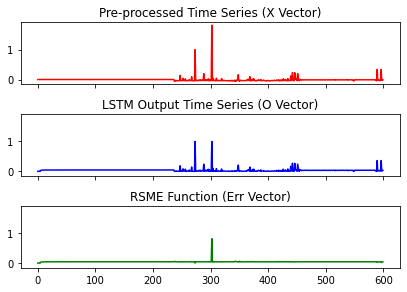

In [8]:
n=300

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.tight_layout(h_pad=2)
axs[0].set_title("Pre-processed Time Series (X Vector)")
axs[0].plot(x[n,:], 'r')
axs[1].set_title("LSTM Output Time Series (O Vector)")
axs[1].plot(predicted[n,:], 'b')
axs[2].set_title("RSME Function (Err Vector)")
axs[2].plot(np.sqrt((x[n,:]-predicted[n,:])**2),'g')

#plt.savefig("LSTM_output_and_error.png")

In [9]:
errors=np.sqrt((x-predicted)**2)

# Data Description

In [10]:
means=[]
for err in errors:
    means.append(np.mean(err))
    
means=np.array(means)

In [11]:
maxes=[]
for err in errors:
    maxes.append(np.max(err))
    
maxes=np.array(maxes)

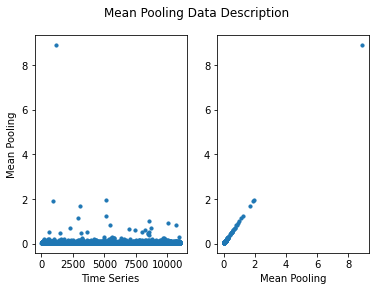

In [12]:
fig, axs = plt.subplots(1,2)
fig.suptitle("Mean Pooling Data Description")
axs[0].set_xlabel("Time Series")
axs[0].set_ylabel("Mean Pooling")
axs[0].scatter(range(means.shape[0]),means, s=10)
axs[0].set_ylabel("Mean Pooling")
axs[1].set_xlabel("Mean Pooling")
axs[1].scatter(means,means, s=10)

plt.savefig("Mean_Pooling_Uncolored")

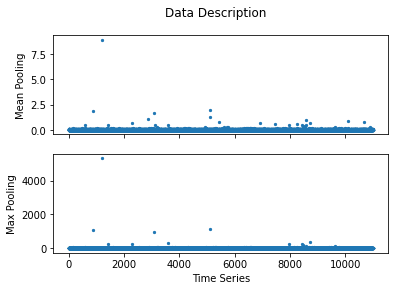

In [13]:
fig, axs = plt.subplots(2,1, sharex=True)
fig.suptitle("Data Description")
axs[1].set_xlabel("Time Series")
axs[0].set_ylabel("Mean Pooling")
axs[0].scatter(range(means.shape[0]),means, s=5)
axs[1].set_ylabel("Max Pooling")
axs[1].scatter(range(maxes.shape[0]),maxes, s=5)

plt.savefig("Data_Description_Uncolored")

In [14]:
data_description=np.concatenate((means.reshape(-1,1),maxes.reshape(-1,1)), axis=1)

In [16]:
scaler=StandardScaler()
rescaled_dd=scaler.fit_transform(data_description)

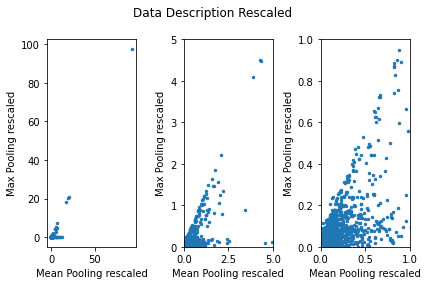

In [21]:

fig, axs= plt.subplots(1,3)
fig.suptitle("Data Description Rescaled")

axs[0].scatter(rescled_dd[:,0],rescled_dd[:,1], s=6)
axs[0].set_xlabel("Mean Pooling rescaled")
axs[0].set_ylabel("Max Pooling rescaled")

axs[1].scatter(rescled_dd[:,0],rescled_dd[:,1], s=6)
axs[1].set_xlabel("Mean Pooling rescaled")
axs[1].set_ylabel("Max Pooling rescaled")
axs[1].set_xlim([0,5])
axs[1].set_ylim([0,5])

axs[2].scatter(rescled_dd[:,0],rescled_dd[:,1], s=6)
axs[2].set_xlabel("Mean Pooling rescaled")
axs[2].set_ylabel("Max Pooling rescaled")
axs[2].set_xlim([0,1])
axs[2].set_ylim([0,1])

fig.tight_layout()

plt.savefig("DD_zoom_uncolored")

In [17]:
lof=LocalOutlierFactor(n_neighbors=30)
lof.fit(rescaled_dd)

LocalOutlierFactor(n_neighbors=30)

In [22]:
lof_labels=lof.fit_predict(rescaled_dd)

In [23]:
lof_labels

array([1, 1, 1, ..., 1, 1, 1])

In [24]:
unique, counts = np.unique(lof_labels, return_counts=True)
dict(zip(unique, counts))

{-1: 365, 1: 10635}

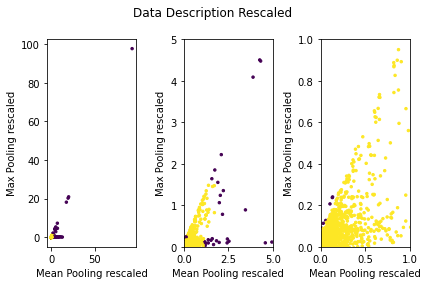

In [25]:

fig, axs= plt.subplots(1,3)
fig.suptitle("Data Description Rescaled")

axs[0].scatter(rescled_dd[:,0],rescled_dd[:,1],c=lof_labels, s=6)
axs[0].set_xlabel("Mean Pooling rescaled")
axs[0].set_ylabel("Max Pooling rescaled")

axs[1].scatter(rescled_dd[:,0],rescled_dd[:,1],c=lof_labels, s=6)
axs[1].set_xlabel("Mean Pooling rescaled")
axs[1].set_ylabel("Max Pooling rescaled")
axs[1].set_xlim([0,5])
axs[1].set_ylim([0,5])

axs[2].scatter(rescled_dd[:,0],rescled_dd[:,1],c=lof_labels, s=6)
axs[2].set_xlabel("Mean Pooling rescaled")
axs[2].set_ylabel("Max Pooling rescaled")
axs[2].set_xlim([0,1])
axs[2].set_ylim([0,1])

fig.tight_layout()


plt.savefig("DD_zoom_colored")